# Major League Baseball Game Logs, EDA Part 2

*The information used here was obtained free of charge from and is copyrighted by Retrosheet.  Interested parties may contact Retrosheet at "www.retrosheet.org".*

## 1. Introduction

When developing a discrete event simulation or a regression model, it is important to understand how the features and response variable are distributed. In an earlier project, we examined the statistics from Major League Baseball (MLB) historical game logs. Here, we focus on how these statistics are distributed. As a reminder, the MLB game logs record the counts of on-field events observed during a game, such as hits, walks, strikeouts, etc. 

The negative-binomial distribution is often cited as the best discrete distribution to model these counting statistics. Many models employ compound distributions, typically using a linear combination of the negative-binomial and Poisson distributions. Discretized continuous distributions, such as the Weibull, have also been successfully applied.

There are, however, potential disadvantages to these approaches. The negative binomial is a good approximation of an over dispersed Poisson distribution but will not work for under dispersed data (see Section 1.1). Compound distributions are more difficult to interpret and estimating the parameters can be computationally expensive. Likewise, with discretizing continuous distributions.

The ideal candidate distribution should have infinite support over the whole numbers. It should minimize the difference between itself and the observed probability mass function (PMF) or cumulative distribution function (CDF). Finally, the candidate distribution should maintain its interpretability. The emphasis on interpretation is related to the goal of easily estimating the distribution parameters. We could, for instance, use a highly flexible distribution that fits the observed data very well. Without a rational method to estimate the parameterization from the data set, fitting the distribution might become expensive, computationally, with no guarantee that the results will generalize.

With those factors in mind, we will evaluate the following four probability distributions.

### 1.1 Negative Binomial Distribution

The obvious first choice might be the Poisson distribution using per-game means as the parameter estimate. Poisson distributions, however, describe fixed-length processes and MLB games are not fixed lengths. Games are measured in innings or, more accurately, outs. For variety of reasons, the number of outs recorded by each team may not equal 27 outs per team one might expect from a nine-inning game. Extra-inning games, home-team wins, and games truncated by poor weather are common occurrences. They are a significant departure from the assumption of a fixed-length process inherit to a Poisson distribution and are characterized by over dispersion or under dispersion, where the estimated variance $\hat{s}^2 > \lambda$ or $\hat{s}^2 < \lambda$, respectively.

The typical way to deal with an over dispersed Poisson distribution is to use a negative binomial distribution. Recall that a negative binomial distribution counts the number of observed failures, $X$, after $n$ successful Bernoulli trials have occurred, each with a probability of success $p$, denoted as $X$~NB$(n,p)$. Now, consider a series of negative binomial random variables where $n \rightarrow \infty$ and the probability of success $p \rightarrow 0$ such that the mean, $\lambda$, is constant. Then the mean is given by

$$\lambda  = \frac{p n}{1-p}$$
or, solving for $p$,
$$p = \frac{\lambda}{n+\lambda}$$

The variance is given by 

$$ \sigma^2 = \frac{np}{(1-p)^2}
$$
or 
$$ \sigma^2 = \lambda + \frac{\lambda^2}{n}
$$

For large values of $n$, the variance converges to $\lambda$ and the negative binomial converges to the Poisson distribution. That is,

$$ Poisson(\lambda) = \lim\limits_{n \rightarrow \infty} NB \left( n, \frac{\lambda}{n+\lambda} \right)
$$

For small values of $n$, the variance is greater than $\lambda$ (over dispersion). To adapt the typical negative binomial distribution to an over dispersed Poisson distribution is simply a matter of finding expressions for $n$ and $p$ in terms of the mean and variance. We will omit the algebra, but the result is

$$ p = \frac{\lambda}{\sigma^2}
$$
and 

$$n=\frac{\lambda^2}{\sigma^2-\lambda}
$$

Then $NB(r,p)$ becomes $NB \left(\frac{\lambda^2}{\sigma^2-\lambda},\frac{\lambda}{\sigma^2} \right)$. This reparameterization of the negative-binomial is perhaps the most frequent approach used to model an over dispersed Poisson random variable. Notice, however, that when the data is under dispersed, the reparameterization results in a negative value for $n$ and a value of $p>1$. In those cases, an alternative distribution will be required.



### 1.2 Binomial Distribution

The binomial distribution counts the number of successes in $n$ Bernoulli trials, each with a probability of success $p$, denoted $X$~Binom($n,p$). Parameter estimation and interpretation of the binomial distribution is straightforward and so we include it for consideration here.



### 1.3 Beta-binomial Distribution

The beta-binomial distribution is a conjugate to binomial distribution where the probability of success is unknown or random, and drawn from a beta distribution, denoted $X$~BetaBinom($n,\alpha,\beta$). It is often used to model over dispersion in binomial random variables, so we include it for consideration with the binomial distribution.



### 1.3 Poisson Distribution

For the reasons addressed above, the Poisson distribution may not be appropriate to model the game-log data. However, we will include it for consideration in this analysis.

## 2. Motivation

Evaluate the performance of the four candidate distributions when applied to game-log data. The primary goal is to find which of the parametric distributions discussed in Section 1 best fits the observed data while maintaining interpretability and ease of parameter estimation. Furthermore, we will identify circumstances where a distribution is not appropriate and suggest alternatives. 

The CSV file of the game-log data has the following columns:

**Offensive Categories**
- *season*: Season in which game is played (year).
- *league*: League of the home team.
- *win*: Indicator of win or loss.
- *score*: Number of runs scored by a team's offense.
- *ab*: Number of at-bats for a team's offense. An official at-bat comes when a batter reaches base via a fielder's choice, hit or an error (not including catcher's interference) or when a batter is put out on a non-sacrifice.
- *1b*: Number singles for a team's offense.
- *2b*: Number of doubles for a team's offense.
- *3b*: Number of triples for a team's offense.
- *4b*: Number of home runs for a team's offense.
- *sach*: Number of sacrifice hits (or sacrifice bunts) for a team's offense. A sacrifice bunt occurs when a player is successful in his attempt to advance a runner (or multiple runners) at least one base with a bunt.
- *sacf*: Number of sacrifice flies for a team's offense. A sacrifice fly occurs when a batter hits a fly-ball out to the outfield or foul territory that allows a runner to score. The batter is given credit for an RBI.
- *hbp*: Number of hit-by-pitches for a team's offense. A hit-by-pitch occurs when a batter is struck by a pitched ball without swinging at it. He is awarded first base as a result. Strikes supersede hit-by-pitches, meaning if the umpire rules that the pitch was in the strike zone or that the batter swung, the HBP is nullified.
- *bb*: Number of base-on-balls (walks) for a team's offense. A walk (or base on balls) occurs when a pitcher throws four pitches out of the strike zone, none of which are swung at by the hitter. After refraining from swinging at four pitches out of the zone, the batter is awarded first base. In the scorebook, a walk is denoted by the letters BB.
- *ibb*: Number of intentional base-on-balls (walks) for a team's offense. An intentional walk occurs when the defending team chooses to walk a batter on purpose, putting him on first base instead of letting him try to hit.
- *k*: Number of strikeouts for a team's offense.
- *sb*: Number of stolen bases for a team.
- *cs*: Number of caught stealing for a team.
- *gidp*: Number of grounded-into-double-plays for a team's offense. A GIDP occurs when a player hits a ground ball that results in multiple outs on the bases.
- *ci*: Number of catcher's interference awarded to a teams' offense. The batter is awarded first base if the catcher (or any other fielder) interferes with him at any point during a pitch. If first base was occupied at the time of the pitch, the runner who held the base is allowed to move up one base.
- *lob*: The total number (over the course of a game) of runners left on base at the end of each inning by a team's offense.

**Defensive Categories**

- *numPitchers*: Number of pitchers appearing in the for a team's defense.
- *er*: Number of earned runs surrendered by a team's defense. An earned run is any run that scores against a pitcher without the benefit of an error or a passed ball.
- *teamER*: Number of earned runs surrendered by a team's defense that is not assigned to a specific pitcher.
- *wp*: Number of wild pitches surrendered by a team's defense. A pitcher is charged with a wild pitch when his pitch is so errant that the catcher is unable to control it and, as a result, baserunner(s) advance.
- *balk*: Number of balks surrendered by a team's defense. A balk occurs when a pitcher makes an illegal motion on the mound that the umpire considers to be deceitful to the runner(s).
- *po*: Number of putouts recorded by a team's defense. A fielder is credited with a putout when he is the fielder who physically records the act of completing an out -- whether it be by stepping on the base for a forceout, tagging a runner, catching a batted ball, or catching a third strike.
- *assist* Number of assists recorded by a team's defense. An assist is awarded to a fielder who touches the ball before a putout is recorded by another fielder. Typically, assists are awarded to fielders when they throw the ball to another player -- but a fielder receives an assist if he touches the ball, even if the contact was unintentional.
- *err*: Number of errors recorded by a team's defense. A fielder is given an error if, in the judgment of the official scorer, he does not convert an out on a play that an average fielder should have made. Fielders can also be given errors if they make a poor play that allows one or more runners to advance on the bases.
- *pb*: Number of passed balls recorded by a team's defense. A catcher is charged with a passed ball when he does not hold or control a legally pitched ball that, with ordinary effort, should have been maintained under his control, and, because of this loss of control, the batter or a runner on base advances. A runner who advances due to a passed ball is not credited with a stolen base unless he breaks for the base before the pitcher begins his delivery.
- *dp*: Number of double plays recorded by a team's defense. A double play occurs when two offensive players are ruled out within the same play.
- *tp*: Number of triple plays recorded by a team's defense. A triple play occurs when three offensive players are ruled out within the same play.

## 3. Analysis

### 3.1 Imports and Function Definitions

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.stats as ss
import numpy as np

In [23]:
def getEmpircalMoments(dataIn):
    """
    Parameters
    ----------
    dataIn : List, array, or dataframe series
        Emperical data under consideration.

    Returns
    -------
    First four moments of the empirical distribution.

    """
    if type(dataIn)=='list':
        dataIn = np.array(dataIn)

    moments = np.array([dataIn.mean(),
                        dataIn.var(),
                        ss.skew(dataIn, nan_policy='omit'),
                        ss.kurtosis(dataIn, nan_policy='omit')])

    return(moments)

def getEmpDists(listIn):
    """
    Parameters
    ----------
    listIn : List/Array
        Values from which this function will generate an empircal PMF and CDF.

    Returns
    -------
    Empircal PMF, CDF, and support k.

    """
    if type(listIn)!=list:
        listIn = list(listIn.dropna())
    elements = set(listIn)
    n = len(listIn)
    k = range(int(max(elements))+1)
    pmfOut = np.array([listIn.count(e)/n for e in k])
    cdfFunct = ECDF(listIn)
    cdfOut = cdfFunct(range(int(max(elements))+1))
    return(pmfOut,cdfOut,k)

def paramDistFunct(name, p):
    """
    Parameters
    ----------
    name : String
        Name of the probability distribution.
    p : List/array/tuple
        Paramerters to pass to the named distribution.

    Returns
    -------
    PMF and CDF of named distribution.

    """
    if name=='bernoulli':
        pmf = ss.bernoulli.pmf(p[0],p[1],p[2])
        cdf = ss.bernoulli.cdf(p[0],p[1],p[2])
        return(pmf, cdf)
    elif name=='betabinom':
        pmf = ss.betabinom.pmf(p[0],p[1],p[2],p[3],p[4])
        cdf = ss.betabinom.cdf(p[0],p[1],p[2],p[3],p[4])
        return(pmf, cdf)
    elif name=='binom':
        pmf = ss.binom.pmf(p[0],p[1],p[2],p[3])
        cdf = ss.binom.cdf(p[0],p[1],p[2],p[3])
        return(pmf, cdf)
    elif name=='boltzmann':
        pmf = ss.boltzmann.pmf(p[0],p[1],p[2],p[3])
        cdf = ss.boltzmann.cdf(p[0],p[1],p[2],p[3])
        return(pmf, cdf)
    elif name=='geom':
        pmf = ss.geom.pmf(p[0],p[1],p[2])
        cdf = ss.geom.cdf(p[0],p[1],p[2])
        return(pmf, cdf)
    elif name=='hypergeom':
        pmf = ss.hypergeom.pmf(p[0],p[1],p[2],p[3],p[4])
        cdf = ss.hypergeom.cdf(p[0],p[1],p[2],p[3],p[4])
        return(pmf, cdf)
    elif name=='logser':
        pmf = ss.logser.pmf(p[0],p[1],p[2])
        cdf = ss.logser.cdf(p[0],p[1],p[2])
        return(pmf, cdf)
    elif name=='nbinom':
        pmf = ss.nbinom.pmf(p[0],p[1],p[2],p[3])
        cdf = ss.nbinom.cdf(p[0],p[1],p[2],p[3])
        return(pmf, cdf)
    elif name=='nchypergeom_fisher':
        pmf = ss.nchypergeom_fisher.pmf(p[0],p[1],p[2],p[3],p[4],p[5])
        cdf = ss.nchypergeom_fisher.cdf(p[0],p[1],p[2],p[3],p[4],p[5])
        return(pmf, cdf)
    elif name=='planck':
        pmf = ss.planck.pmf(p[0],p[1],p[2])
        cdf = ss.planck.cdf(p[0],p[1],p[2])
        return(pmf, cdf)
    elif name=='poisson':
        pmf = ss.poisson.pmf(p[0],p[1],p[2])
        cdf = ss.poisson.cdf(p[0],p[1],p[2])
        return(pmf, cdf)
    elif name=='randint':
        pmf = ss.randint.pmf(p[0],p[1],p[2],p[3])
        cdf = ss.randint.cdf(p[0],p[1],p[2],p[3])
        return(pmf, cdf)
    elif name=='skellam':
        pmf = ss.skellam.pmf(p[0],p[1],p[2],p[3])
        cdf = ss.skellam.cdf(p[0],p[1],p[2],p[3])
        return(pmf, cdf)
    elif name=='yulesimon':
        pmf = ss.yulesimon.pmf(p[0],p[1],p[2])
        cdf = ss.yulesimon.cdf(p[0],p[1],p[2])
        return(pmf, cdf)
    elif name=='zipf':
        pmf = ss.zipf.pmf(p[0],p[1],p[2])
        cdf = ss.zipf.cdf(p[0],p[1],p[2])
        return(pmf, cdf)
    else:
        print(f'Dist name={name} not available.')
        return(None)

def getLoss(a0,a1):
    """
    Parameters
    ----------
    a0 : Array
        Emprical PDF/CDF of observed data.
    a1 : Array
        Parametric PDF/CDF under consideration.

    Returns
    -------
    Standard deviation of the difference between a0 and a1 as a fit score. Can be 
    applied the first four moments or directly to PDF/CDF.
    """
    L = (a0-a1).std()
    return(L)

### 3.2 Load Data

In [25]:
# load data without index column
df = pd.read_csv('https://github.com/cmtoner/retrosheets-game-logs/raw/main/rs_GameLog_data01.zip', index_col=0)

df.head()

,season,league,win,score,ab,1b,2b,3b,4b,sach,...,er,teamER,wp,balk,po,assist,err,pb,dp,tp
0,1933,ML,1,4,31.0,8.0,0.0,0.0,1.0,1.0,...,2.0,2.0,0.0,0.0,27.0,11.0,1.0,0.0,1.0,0.0
1,1935,ML,1,4,32.0,4.0,2.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,27.0,10.0,0.0,0.0,0.0,0.0
2,1937,ML,1,8,35.0,8.0,3.0,1.0,1.0,0.0,...,3.0,3.0,0.0,0.0,27.0,15.0,2.0,0.0,0.0,0.0
3,1939,ML,1,3,31.0,5.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,27.0,9.0,1.0,0.0,1.0,0.0
4,1941,ML,1,7,36.0,7.0,3.0,0.0,1.0,0.0,...,5.0,5.0,0.0,0.0,27.0,11.0,3.0,0.0,1.0,0.0


### 3.3 Calculate the Fit

Calculate the fit of the parametric distributions to the empirical distributions using (1) method of moments and (2) by calculating the loss of the PMF/CDF directly over the support.


Note: Because this is count data, we will use the variance-to-mean ratio (VMR) to describe the dispersion of the data. A Poisson distribution has a VMR of 1 and values other than 1 are evidence of a dispersion problem.

Parametric distributions
- Poisson: 
 - $k=$support; 
 - $\lambda=$mean($x$)
- Binomial: 
 - $k=$support; 
 - $n=$mean(at bats); 
 - $p=$sum(x)/sum(at bats)
- Negative-binomial (alternative parameterization for over dispersed Poisson data): 
 - $k=$support; 
 -$n=\frac{\mu^2}{\sigma^2-\mu}$; 
 - $p=\frac{\mu}{\sigma^2}$
- Beta-binomial: 
 - $k=$support; 
 - $n=$mean(at bats); 
 - $\alpha=$mean($x$); 
 - $\beta=n-\alpha$





In [26]:
# Evaluate the fit of the parametic distribution based on two loss functions
# that (1) compare the observed/parametric moments and (2) compare the observed
# and parametric PMF/CDF

# create df to store results
# dist=>distribution under consideration;
# fitScore0 = fit score by method of moments
# fitscore1 => fit score by PMF
# fitscore2 => fit score by CDF
# vmr -> variance to mean ratio (measure of dispersion)
fitResults = pd.DataFrame(columns=['stat','season','wL','dist','fitScore0','fitScore1','fitScore2','vmr'])
ix = 0

# set up loops
stats = ['score','1b','2b','3b','4b','hbp','bb','ibb',
         'k','sb','cs','gidp','lob','numPitchers','er','teamER','wp',
         'balk','po','assist','err','pb','dp']
seasons = list(range(1920,2022,1))

for stat in stats:
    for season in seasons:
        for wL in [0,1]:

            # slice df
            m0 = (df.season==season)&(df.win==wL)

            # calc observed distributions (and the support)
            obsPMF, obsCDF, k = getEmpDists(df[m0][stat])
            # calc observed moments
            obsMVSK = getEmpircalMoments(df[m0][stat])

            # var-to-mean ratio
            vMR = df[m0][stat].var()/df[m0][stat].mean()            

            # calc Poisson dist
            # params = [k, lambda, loc]
            paramPMF, paramCDF = paramDistFunct('poisson', [k, obsMVSK[0], 0])
            # calc Poisson moments
            paramMVSK = np.array(ss.poisson.stats(obsMVSK[0], loc=0, moments='mvsk'))
            # calc losses
            fS0 = getLoss(obsMVSK,paramMVSK)
            fS1 = getLoss(obsPMF,paramPMF)
            fS2 = getLoss(obsCDF,paramCDF)
            # add to fitResults
            fitResults.loc[ix] = [stat, season, wL, 'poisson0', fS0, fS1, fS2, vMR]
            ix += 1

            # calc Binomial. n=mean(ab), p=sum(stat)/sum(ab)
            n = df[m0].ab.mean()
            p = df[m0][stat].sum()/df[m0]['ab'].sum()
            # get parametric dists. Params => [k,n,p,loc]
            paramPMF, paramCDF = paramDistFunct('binom', [k,n,p,0])
            # get binom moments
            paramMVSK = np.array(ss.binom.stats(n,p,loc=0,moments='mvsk'))
            # calc losses
            fS0 = getLoss(obsMVSK,paramMVSK)
            fS1 = getLoss(obsPMF,paramPMF)
            fS2 = getLoss(obsCDF,paramCDF)
            # add to fitResults
            fitResults.loc[ix] = [stat, season, wL, 'binom0', fS0, fS1, fS2, vMR]
            ix += 1

            # calc negative binomial (as overdispersed Poisson)
            # Params => n=mu^2/(sig^2-mu) and p = mu/sig^2
            n = df[m0][stat].mean()**2 / (df[m0][stat].var()-df[m0][stat].mean())
            p = df[m0][stat].mean()/df[m0][stat].var()
            # get parametric dists. Params => [k,n,p,loc]
            paramPMF, paramCDF = paramDistFunct('nbinom', [k,n,p,0])
            # get binom moments
            paramMVSK = np.array(ss.nbinom.stats(n,p,loc=0,moments='mvsk'))
            # calc losses
            fS0 = getLoss(obsMVSK,paramMVSK)
            fS1 = getLoss(obsPMF,paramPMF)
            fS2 = getLoss(obsCDF,paramCDF)
            # add to fitResults
            fitResults.loc[ix] = [stat, season, wL, 'nbinom0', fS0, fS1, fS2, vMR]
            ix += 1

            #calc beta-binomial 
            # params n=mean(ab), a=mean(stat), b=n-a
            n = df[m0]['ab'].mean()
            a = df[m0][stat].mean()
            b = n-a
            # get parametric dists. Params => [k,n,a,b,loc]
            paramPMF, paramCDF = paramDistFunct('betabinom', [k,n,a,b,0])
            # get binom moments
            paramMVSK = np.array(ss.betabinom.stats(n,a,b,loc=0,moments='mvsk'))
            # calc losses
            fS0 = getLoss(obsMVSK,paramMVSK)
            fS1 = getLoss(obsPMF,paramPMF)
            fS2 = getLoss(obsCDF,paramCDF)
            # add to fitResults
            fitResults.loc[ix] = [stat, season, wL, 'betabinom0', fS0, fS1, fS2, vMR]
            ix += 1

#clean house
del(a,b,fS0, fS1,fS2,ix,m0,n,obsCDF,obsMVSK,obsPMF,paramCDF,paramMVSK,paramPMF,vMR)
del(season,stat,wL)
del(p)

### 3.4 Plot Results

#### 3.4.1 Results by Distribution

Text(0.5, 1.0, 'CDF Loss')

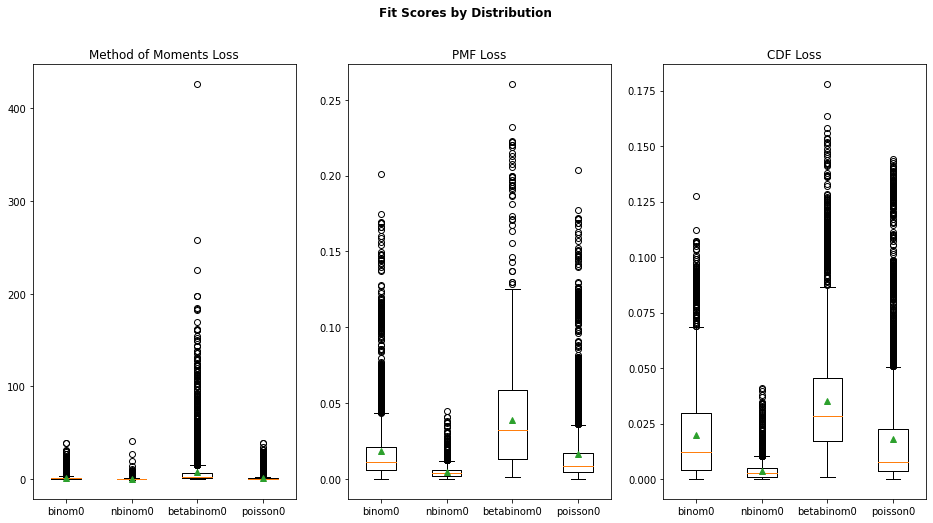

In [27]:
# drop na's from results
fitResults1 = fitResults.dropna()

# suppress VisibleDeprecationWarning
# this warning occurs when boxplot data contains NaNs or null values
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# Create dict for boxplots
bpData = {}

fig = plt.figure(figsize=(16,8),tight_layout=False)
fig.suptitle('Fit Scores by Distribution',
             fontweight='bold')

# Plot moment fit scores
for d in set(fitResults1.dist.tolist()):
    bpData[d] = fitResults1[fitResults1.dist==d].fitScore0.tolist()
    
ax0 = plt.subplot(1,3,1)

ax0.boxplot([bpData[key] for key in bpData.keys()],
            showmeans=True)
ax0.set_xticks(range(1,len(bpData)+1,1))
ax0.set_xticklabels(list(bpData.keys()))
ax0.set_title('Method of Moments Loss')

# Plot PMF fit scores
bpData = {}

for d in set(fitResults1.dist.tolist()):
    bpData[d] = fitResults1[fitResults1.dist==d].fitScore1.tolist()
    
ax1 = plt.subplot(1,3,2)

ax1.boxplot([bpData[key] for key in bpData.keys()],
            showmeans=True)
ax1.set_xticks(range(1,len(bpData)+1,1))
ax1.set_xticklabels(list(bpData.keys()))
ax1.set_title('PMF Loss')

# plot CDF fit scores
bpData = {}

for d in set(fitResults1.dist.tolist()):
    bpData[d] = fitResults1[fitResults1.dist==d].fitScore2.tolist()
    
ax2 = plt.subplot(1,3,3)

ax2.boxplot([bpData[key] for key in bpData.keys()],
            showmeans=True)
ax2.set_xticks(range(1,len(bpData)+1,1))
ax2.set_xticklabels(list(bpData.keys()))
ax2.set_title('CDF Loss')

In [28]:
# clean house
del(ax0, ax1, ax2, bpData, d, fig)

#### 3.4.2 Results by Statistic



                  fitScore0  fitScore1  fitScore2       vmr
stat  dist                                                 
score betabinom0   0.444578   0.008501   0.011923  1.568538
      binom0       1.232184   0.025439   0.040514  1.568538
      nbinom0      0.268330   0.006535   0.007024  1.568538
      poisson0     0.976134   0.020476   0.031949  1.568538




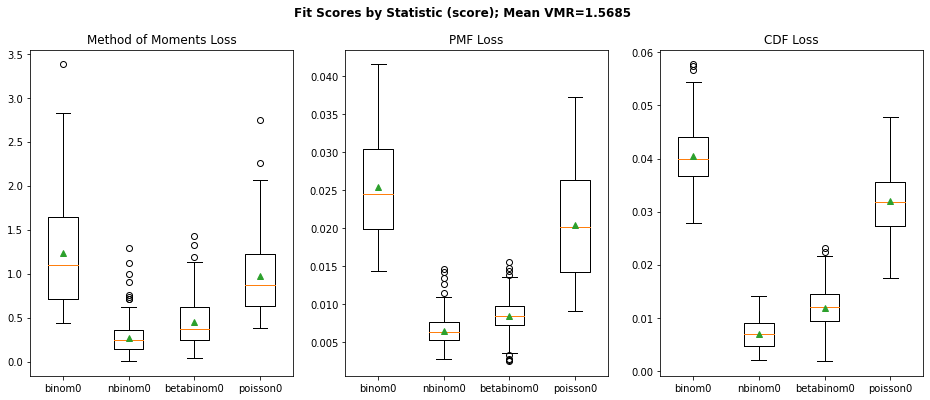



                 fitScore0  fitScore1  fitScore2       vmr
stat dist                                                 
1b   betabinom0   1.165850   0.012738   0.025944  1.152092
     binom0       0.880039   0.012807   0.024097  1.152092
     nbinom0      0.083716   0.004781   0.003966  1.152092
     poisson0     0.404738   0.006818   0.010674  1.152092




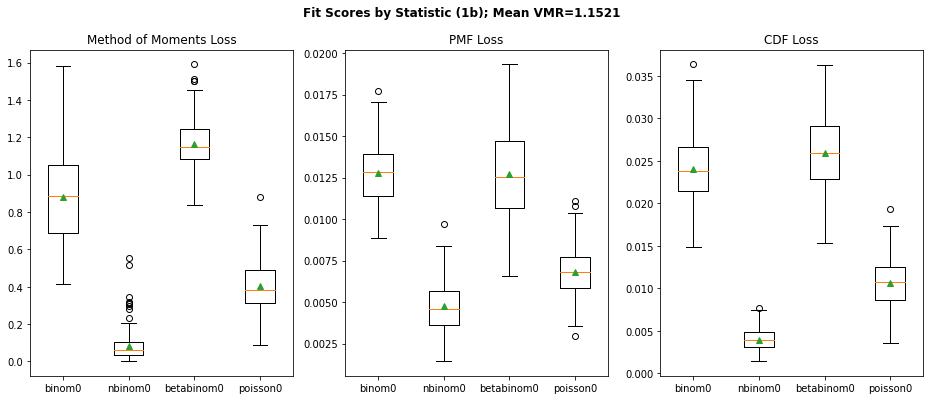



                 fitScore0  fitScore1  fitScore2       vmr
stat dist                                                 
2b   betabinom0   0.877927   0.050727   0.048117  1.059062
     binom0       0.186776   0.010045   0.008667  1.059062
     nbinom0      0.131510   0.005555   0.003546  1.066791
     poisson0     0.157425   0.007565   0.005947  1.059062




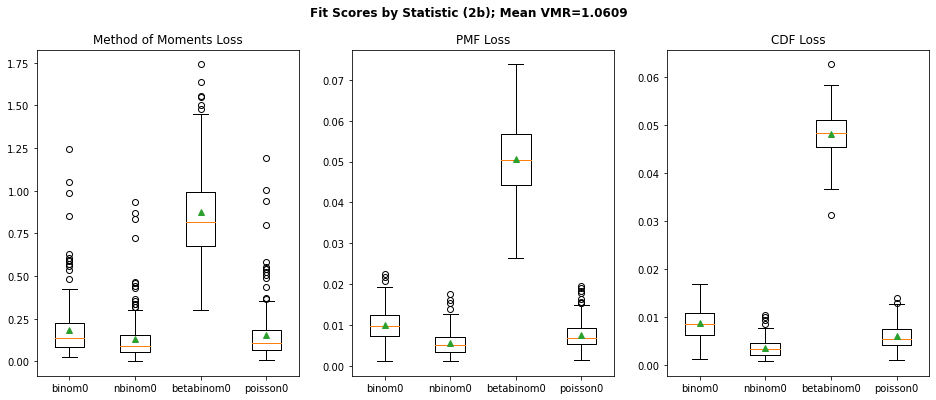



                 fitScore0  fitScore1  fitScore2       vmr
stat dist                                                 
3b   betabinom0   8.323104   0.046482   0.030539  1.044395
     binom0       0.473584   0.005860   0.003663  1.044395
     nbinom0      0.322300   0.002209   0.001272  1.058471
     poisson0     0.451773   0.005271   0.003295  1.044395




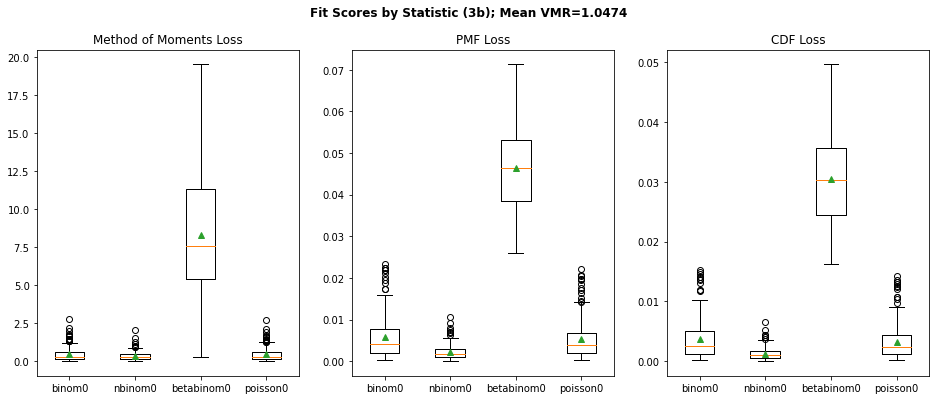



                 fitScore0  fitScore1  fitScore2       vmr
stat dist                                                 
4b   betabinom0   2.448390   0.056972   0.043220  1.079787
     binom0       0.379004   0.011590   0.007901  1.079787
     nbinom0      0.234384   0.004047   0.002440  1.096050
     poisson0     0.340658   0.010173   0.006814  1.079787




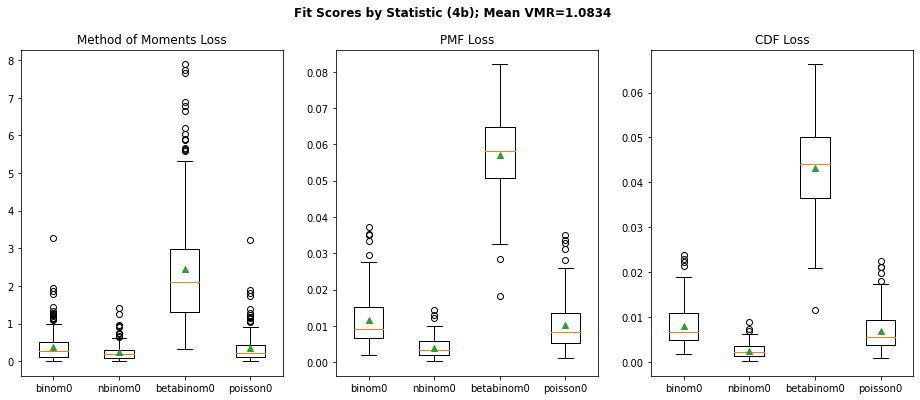



                 fitScore0  fitScore1  fitScore2       vmr
stat dist                                                 
hbp  betabinom0   9.412810   0.042869   0.027862  1.049728
     binom0       0.602526   0.005316   0.003248  1.049728
     nbinom0      0.356073   0.001805   0.001022  1.057192
     poisson0     0.570085   0.004777   0.002915  1.049728




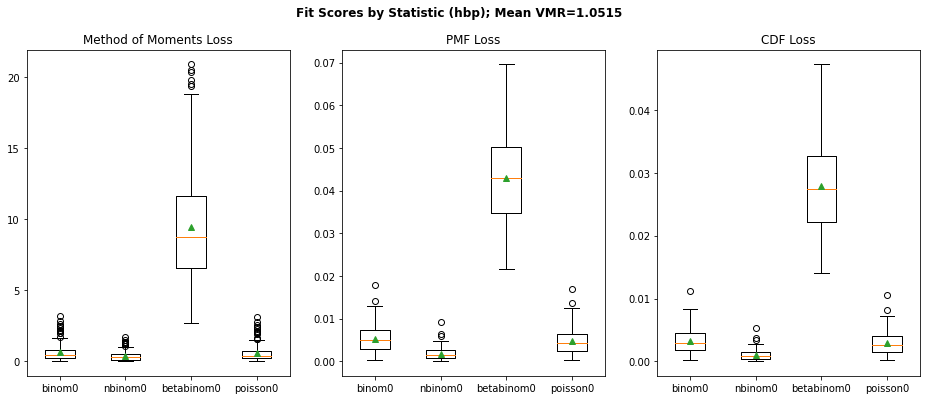



                 fitScore0  fitScore1  fitScore2       vmr
stat dist                                                 
bb   betabinom0   0.566215   0.015893   0.022734  1.344067
     binom0       0.570222   0.019618   0.028000  1.344067
     nbinom0      0.129038   0.005396   0.004025  1.344067
     poisson0     0.454482   0.015076   0.021215  1.344067




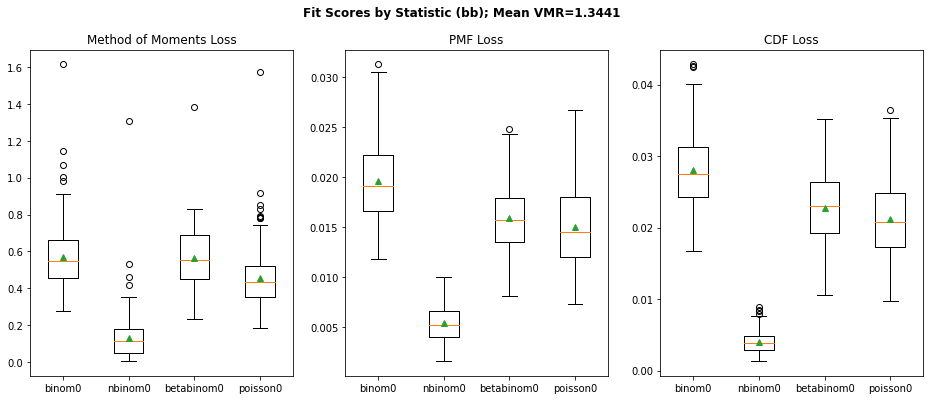



                 fitScore0  fitScore1  fitScore2       vmr
stat dist                                                 
ibb  betabinom0   8.645121   0.033194   0.022257  1.182887
     binom0       2.443105   0.011094   0.007097  1.182887
     nbinom0      1.006292   0.002387   0.001393  1.183843
     poisson0     2.514725   0.011433   0.007086  1.182887




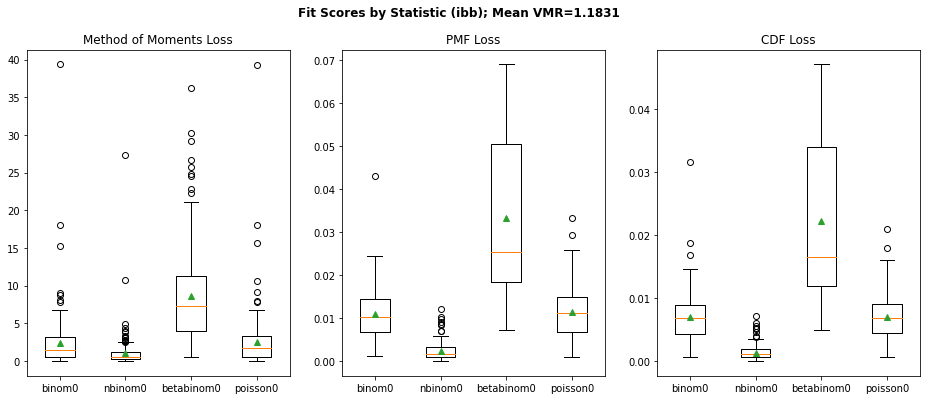



                 fitScore0  fitScore1  fitScore2       vmr
stat dist                                                 
k    betabinom0   0.974050   0.014175   0.025063  1.226247
     binom0       0.754781   0.014570   0.024396  1.226247
     nbinom0      0.143576   0.005092   0.004149  1.231490
     poisson0     0.433487   0.009321   0.013901  1.226247




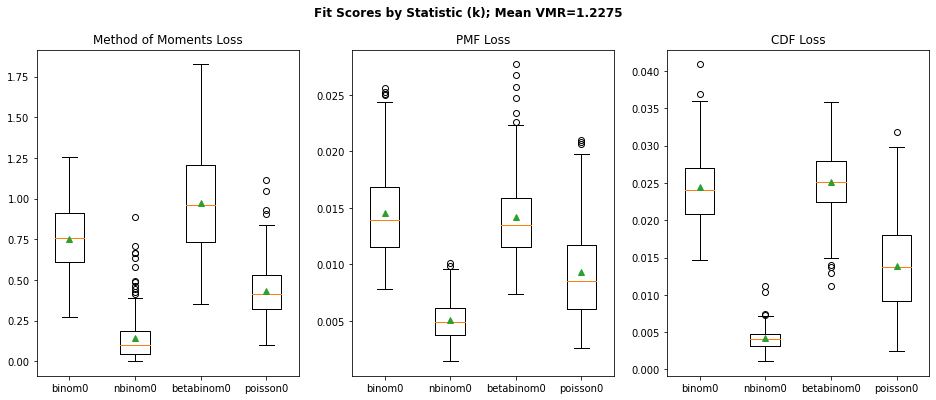



                 fitScore0  fitScore1  fitScore2       vmr
stat dist                                                 
sb   betabinom0   2.786392   0.030614   0.022093  1.326635
     binom0       1.580152   0.028987   0.019585  1.326635
     nbinom0      0.572981   0.003687   0.002266  1.326635
     poisson0     1.521826   0.027400   0.018515  1.326635




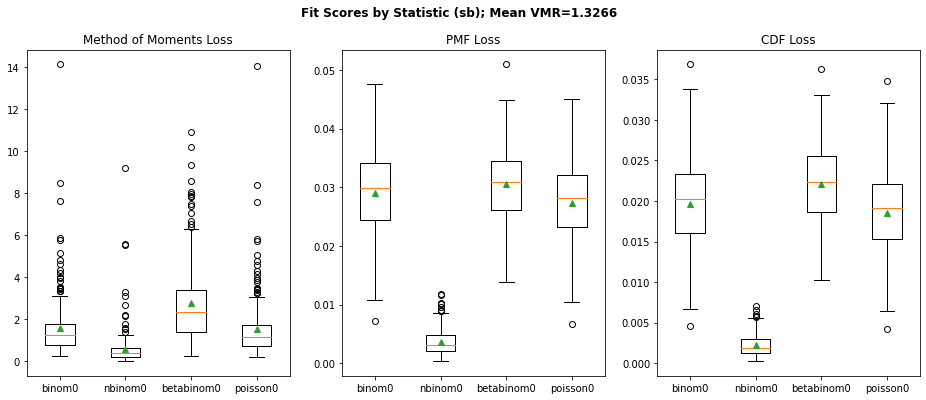



                 fitScore0  fitScore1  fitScore2       vmr
stat dist                                                 
cs   betabinom0   7.100963   0.055442   0.036393  1.006719
     binom0       0.289927   0.004255   0.002604  1.006719
     nbinom0      0.230901   0.002039   0.001167  1.039431
     poisson0     0.298681   0.004095   0.002503  1.006719




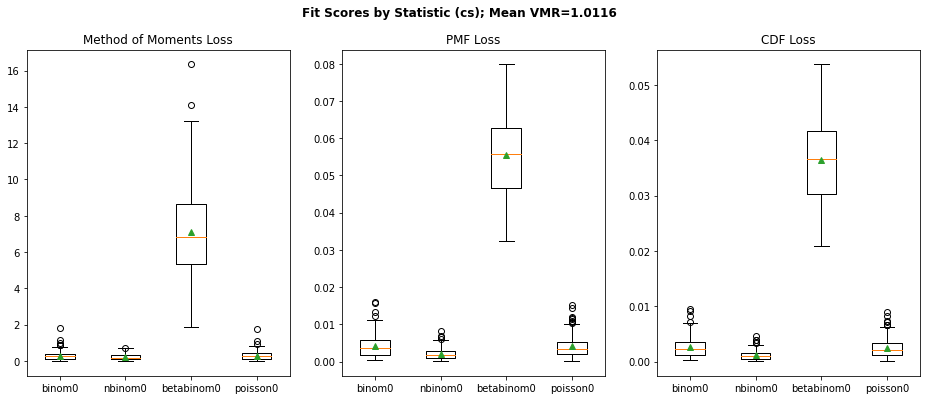



                 fitScore0  fitScore1  fitScore2       vmr
stat dist                                                 
gidp betabinom0   2.377952   0.078466   0.057614  0.957733
     binom0       0.157415   0.009361   0.006493  0.957733
     nbinom0      0.164087   0.005306   0.003129  1.026682
     poisson0     0.173176   0.007831   0.005254  0.957733




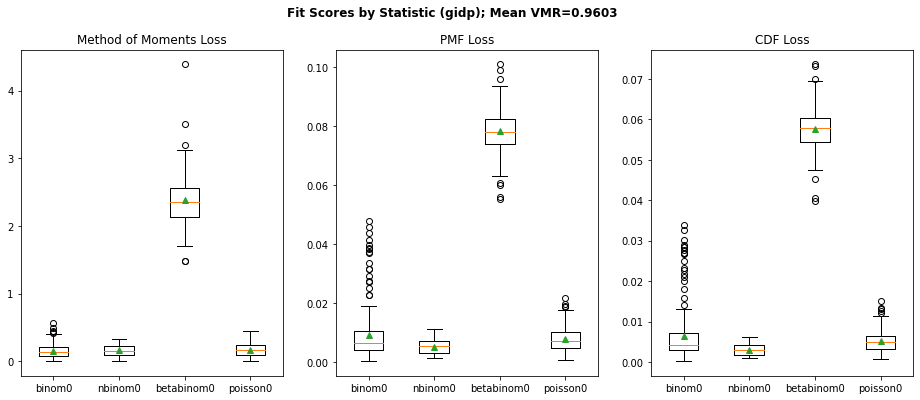



                 fitScore0  fitScore1  fitScore2       vmr
stat dist                                                 
lob  betabinom0   1.743017   0.016001   0.035090  0.989791
     binom0       0.566547   0.008079   0.014251  0.989791
     nbinom0      0.197729   0.004449   0.004077  1.031797
     poisson0     0.217860   0.004999   0.005229  0.989791




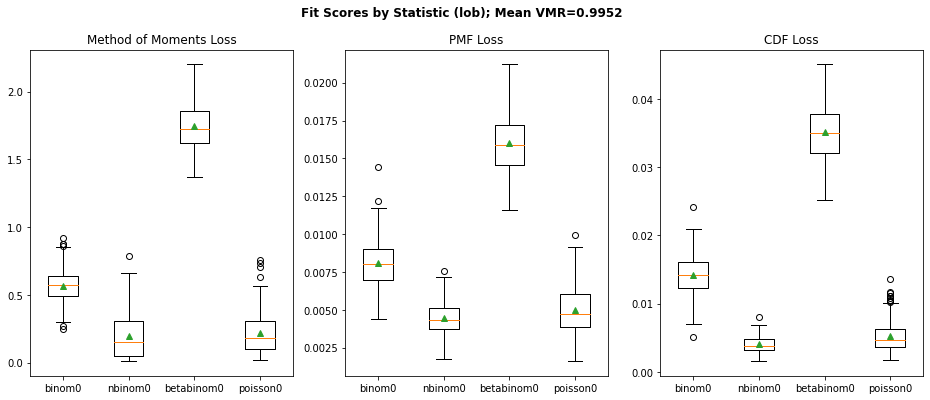



                        fitScore0  fitScore1  fitScore2       vmr
stat        dist                                                 
numPitchers betabinom0   1.438978   0.107336   0.112650  0.498352
            binom0       0.787172   0.066078   0.058525  0.498352
            poisson0     0.848273   0.070425   0.064554  0.498352




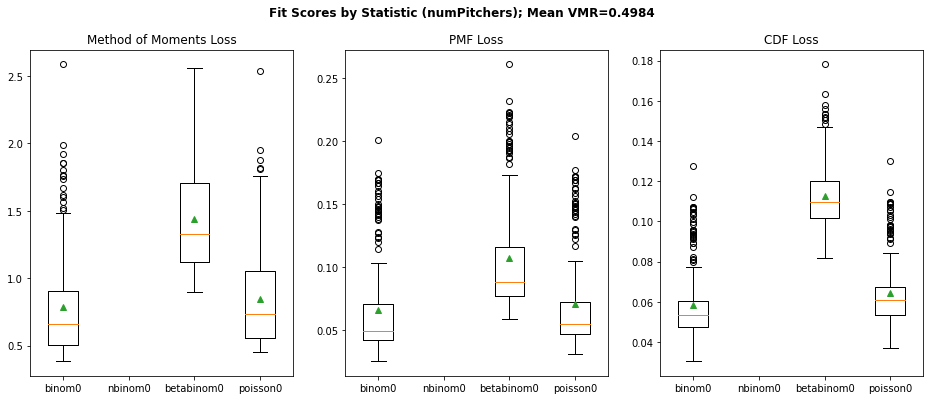



                 fitScore0  fitScore1  fitScore2       vmr
stat dist                                                 
er   betabinom0   0.407476   0.008661   0.011377  1.586877
     binom0       1.110512   0.026583   0.040053  1.586877
     nbinom0      0.248957   0.006410   0.006122  1.586877
     poisson0     0.908156   0.021853   0.032349  1.586877




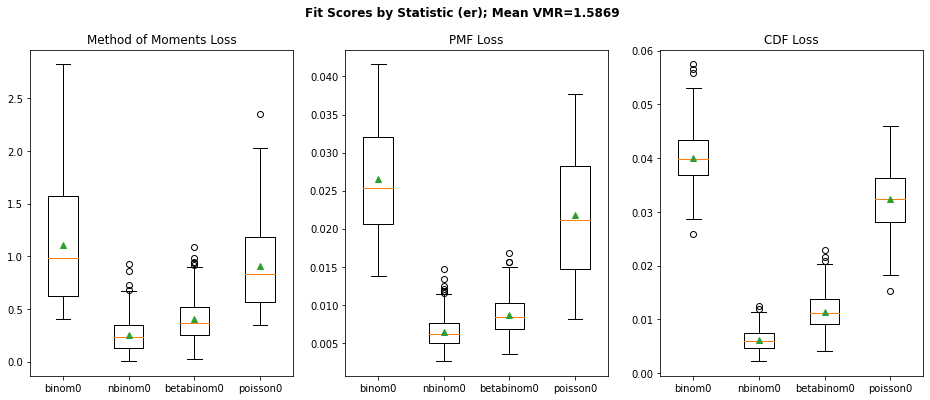



                   fitScore0  fitScore1  fitScore2      vmr
stat   dist                                                
teamER betabinom0   0.586114   0.013851   0.016244  1.73263
       binom0       1.288316   0.032456   0.046010  1.73263
       nbinom0      0.361673   0.011056   0.010005  1.73263
       poisson0     1.101170   0.028123   0.038778  1.73263




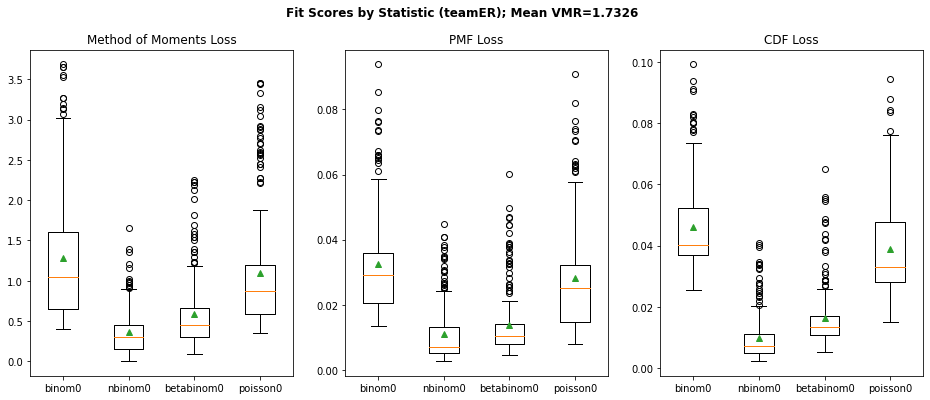



                 fitScore0  fitScore1  fitScore2       vmr
stat dist                                                 
wp   betabinom0   8.157208   0.041050   0.026960  1.088991
     binom0       0.854258   0.008676   0.005360  1.088991
     nbinom0      0.415848   0.002048   0.001175  1.093957
     poisson0     0.804182   0.007992   0.004938  1.088991




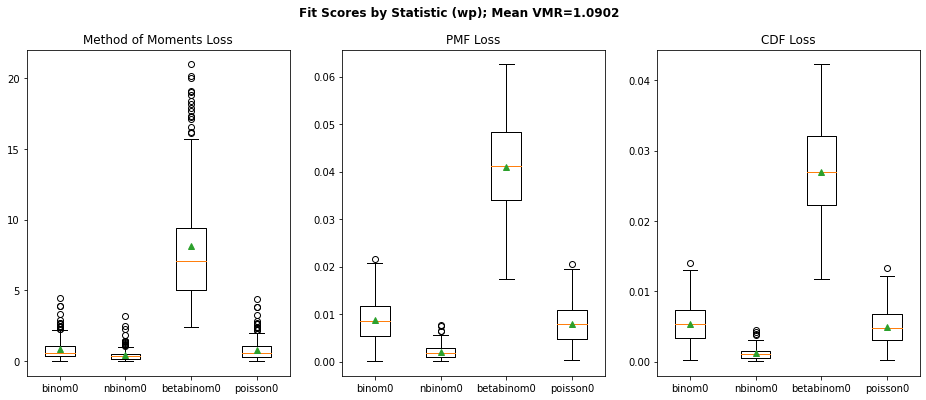



                 fitScore0  fitScore1  fitScore2       vmr
stat dist                                                 
balk betabinom0  80.564763   0.010038   0.006256  1.040589
     binom0       3.670026   0.001186   0.000717  1.040589
     nbinom0      1.810477   0.000352   0.000199  1.080005
     poisson0     3.658410   0.001168   0.000707  1.040589




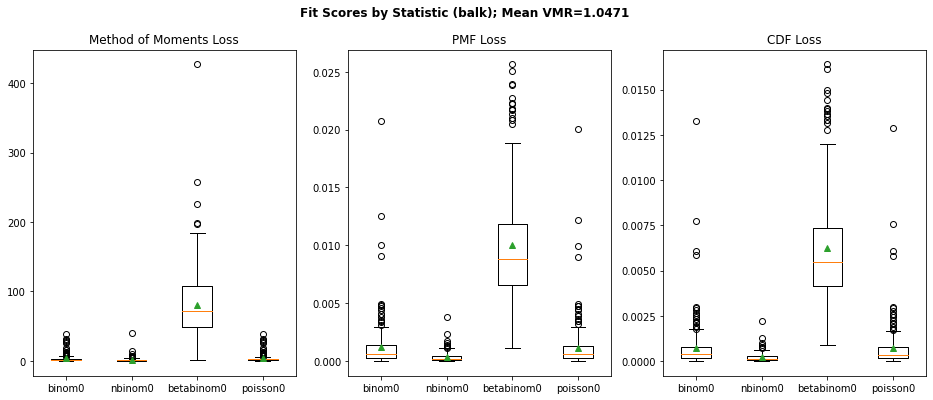



                 fitScore0  fitScore1  fitScore2       vmr
stat dist                                                 
po   betabinom0  11.366254   0.090653   0.084052  0.292754
     binom0      10.446524   0.087121   0.067640  0.292754
     poisson0    16.033526   0.093160   0.108470  0.292754




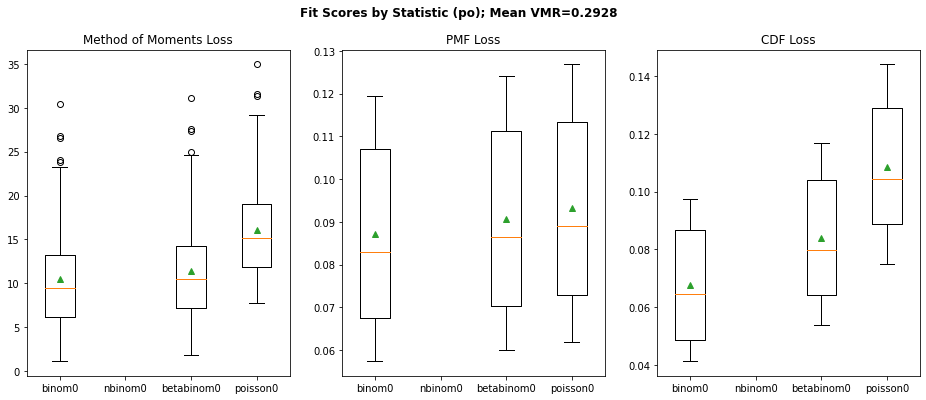



                   fitScore0  fitScore1  fitScore2       vmr
stat   dist                                                 
assist betabinom0   1.460182   0.009328   0.021649  1.139665
       binom0       2.033529   0.011808   0.029227  1.139665
       nbinom0      0.267043   0.006434   0.010405  1.200531
       poisson0     0.822798   0.006090   0.010972  1.139665




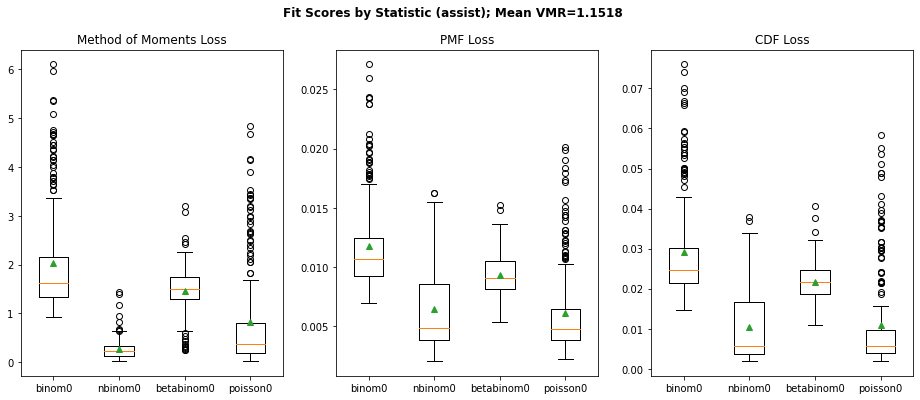



                 fitScore0  fitScore1  fitScore2       vmr
stat dist                                                 
err  betabinom0   1.855854   0.057299   0.044066  1.093561
     binom0       0.288640   0.012539   0.009327  1.093561
     nbinom0      0.155532   0.004532   0.002746  1.095139
     poisson0     0.248056   0.010150   0.007442  1.093561




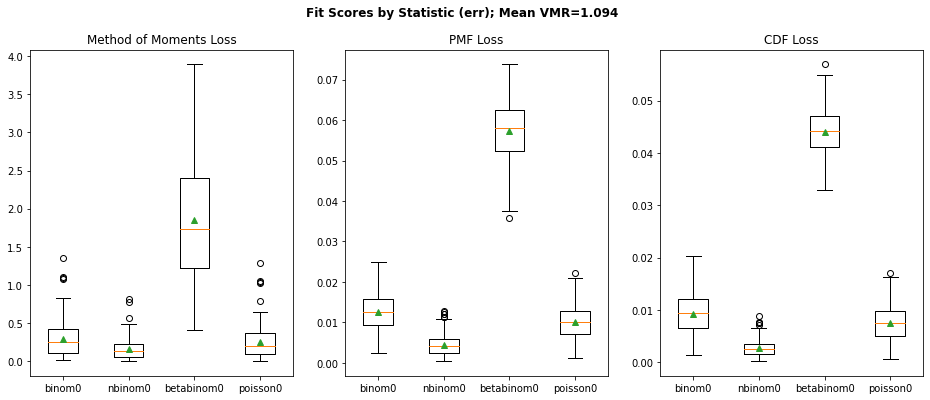



                 fitScore0  fitScore1  fitScore2       vmr
stat dist                                                 
pb   betabinom0  25.648123   0.019829   0.012434  1.062185
     binom0       2.544523   0.002523   0.001509  1.062185
     nbinom0      1.221786   0.000807   0.000460  1.077623
     poisson0     2.505853   0.002444   0.001463  1.062185




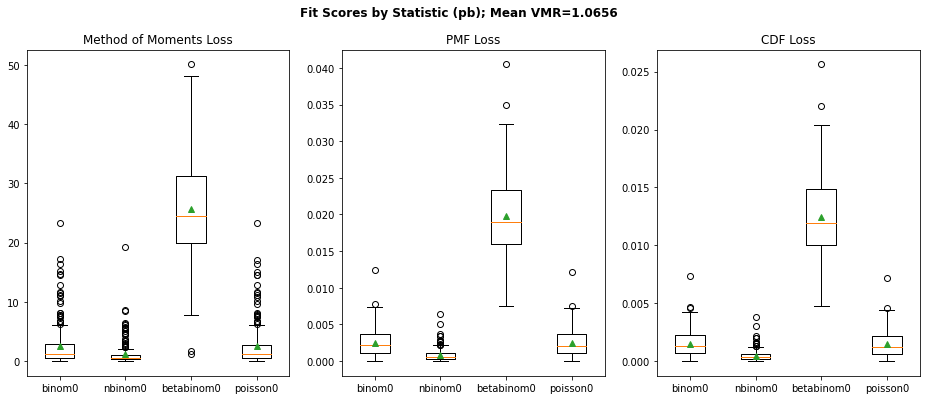



                 fitScore0  fitScore1  fitScore2       vmr
stat dist                                                 
dp   betabinom0   1.826701   0.080078   0.062185  0.932091
     binom0       0.133860   0.007423   0.005129  0.932091
     nbinom0      0.135333   0.004897   0.002958  1.022485
     poisson0     0.170483   0.009633   0.006918  0.932091




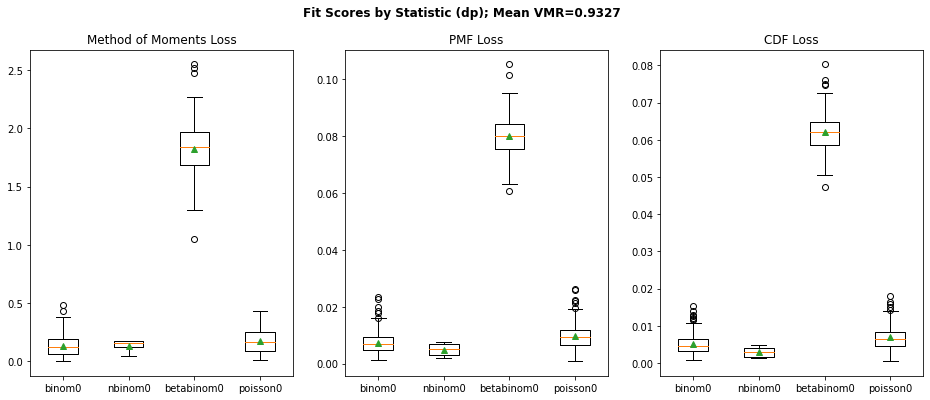

In [29]:
   
# box plot of results by dist,stat
for s in stats:
    # look at group means by stat,distribution
    print('\n')
    print(fitResults1[fitResults1.stat==s].groupby(['stat','dist']).mean())
    print('\n')
    
    # create figure
    fig = plt.figure(figsize=(16,6),tight_layout=False)
    fig.suptitle(f'Fit Scores by Statistic ({s}); Mean VMR={round(fitResults1[fitResults1.stat==s].vmr.mean(),4)}',
                 fontweight='bold')

    # setup dict for boxplots
    bpData = {}
    
    # Plot moment fit scores
    for d in set(fitResults1.dist.tolist()):
        bpData[d] = fitResults1[(fitResults1.dist==d)&(fitResults1.stat==s)].fitScore0.tolist()
        
    ax0 = plt.subplot(1,3,1)

    ax0.boxplot([bpData[key] for key in bpData.keys()],
                showmeans=True)
    ax0.set_xticks(range(1,len(bpData)+1,1))
    ax0.set_xticklabels(list( bpData.keys()))
    ax0.set_title('Method of Moments Loss')

    # Plot PMF fit scores
    bpData = {}

    for d in set(fitResults1.dist.tolist()):
        bpData[d] = fitResults1[(fitResults1.dist==d)&(fitResults1.stat==s)].fitScore1.tolist()
        
    ax1 = plt.subplot(1,3,2)

    ax1.boxplot([bpData[key] for key in bpData.keys()],
                showmeans=True)
    ax1.set_xticks(range(1,len(bpData)+1,1))
    ax1.set_xticklabels(list(bpData.keys()))
    ax1.set_title('PMF Loss')

    # plot CDF fit scores
    bpData = {}
    
    for d in set(fitResults1.dist.tolist()):
        bpData[d] = fitResults1[(fitResults1.dist==d)&(fitResults1.stat==s)].fitScore2.tolist()
        
    ax2 = plt.subplot(1,3,3)

    ax2.boxplot([bpData[key] for key in bpData.keys()],
                showmeans=True)
    ax2.set_xticks(range(1,len(bpData)+1,1))
    ax2.set_xticklabels(list(bpData.keys()))
    ax2.set_title('CDF Loss')
    plt.show()
    
#clean house
del(ax0, ax1, ax2, bpData, d, fig)
del(s)

#### 3.4.3 Empirical vs. Parametric PMF/CDF

The fit scores provide a good measure of performance relative to each other. This does not, however, imply that they are acceptable relative to the empirical data. Here, we will visually inspect the empirical and parametric PMFs/CDFs. Below is a random selection of seasons and statistics and the corresponding probability functions, with the fit scores. 

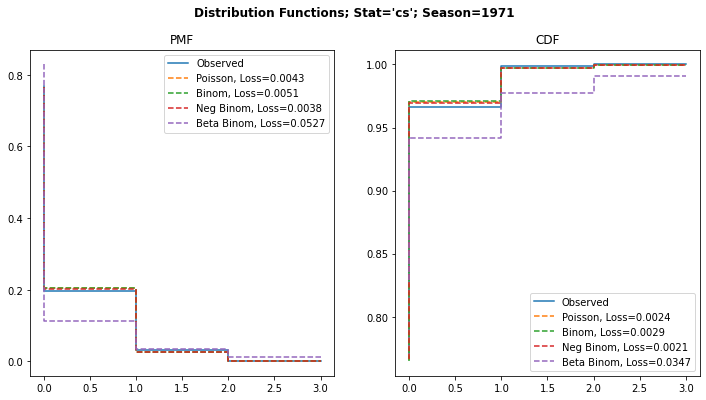

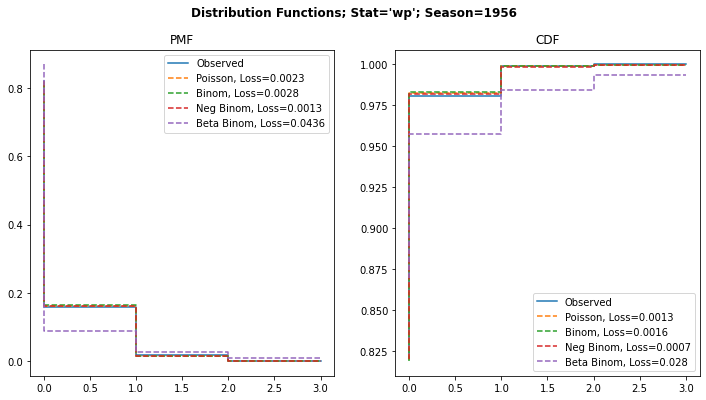

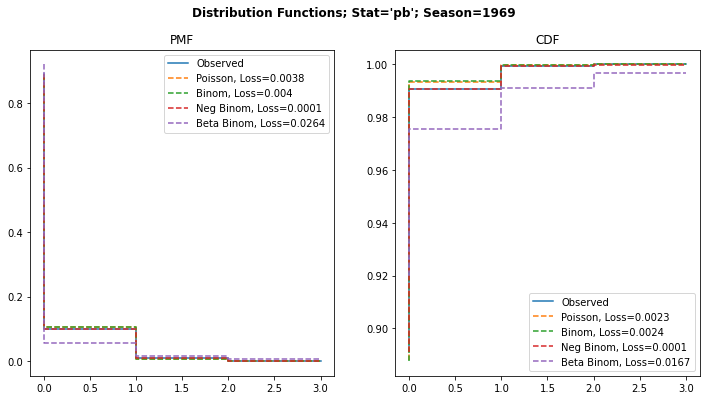

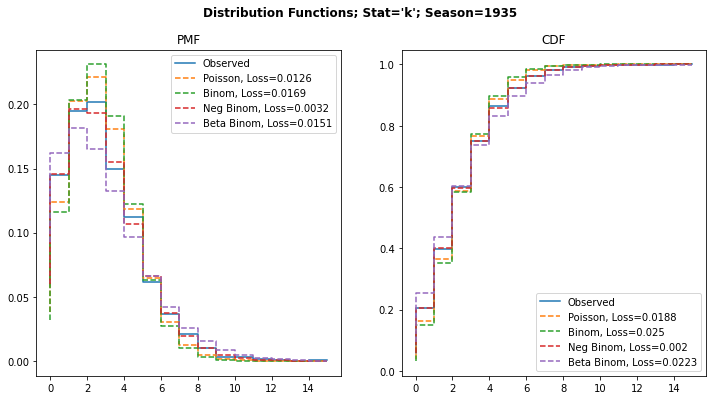

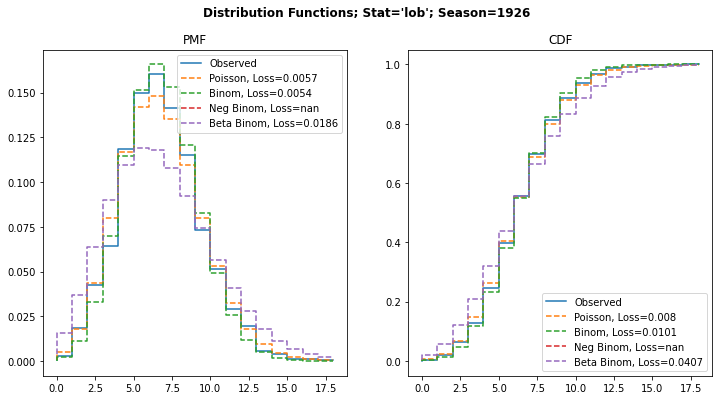

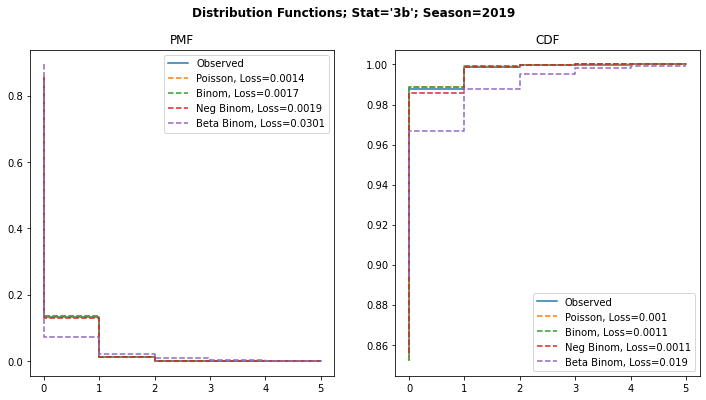

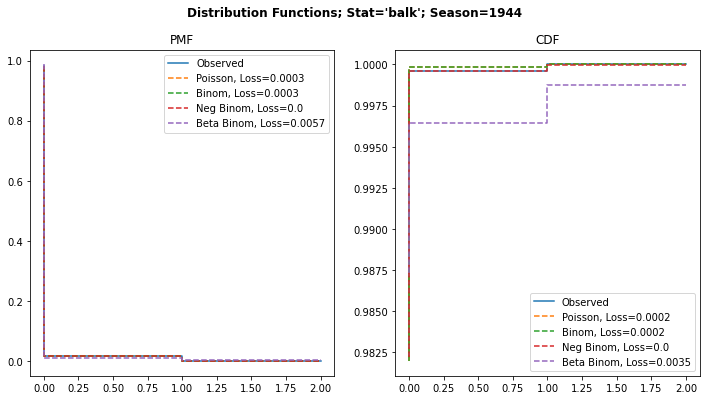

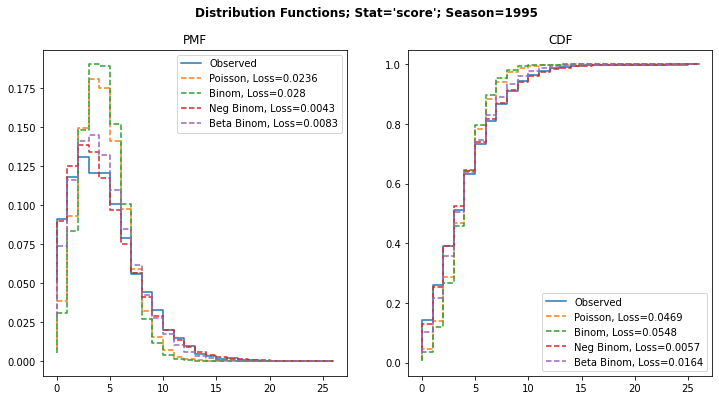

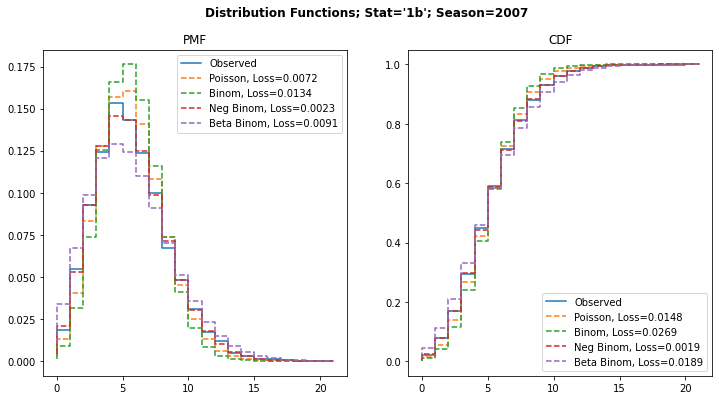

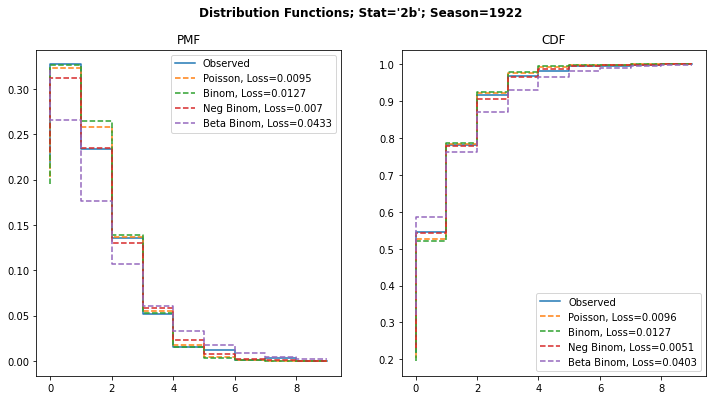

In [30]:
import random as r

randSeasons = list(range(1920,2022,1))
r.shuffle(randSeasons)
r.shuffle(stats)

for ix in range(10):
    # Slice the df
    m0 = (df.season==randSeasons[ix])
    stat = stats[ix]
    
    # calc empirical distrbutions
    obsPMF, obsCDF, k = getEmpDists(df[m0][stat])
    
    # create fig and plot empirical dist
    fig = plt.figure(figsize=(12,6), tight_layout=False)
    fig.suptitle(f"Distribution Functions; Stat='{stat}'; Season={randSeasons[ix]}",
                 fontweight='bold')
    ax0 = plt.subplot(1,2,1)
    ax1 = plt.subplot(1,2,2)
    ax0.step(k,obsPMF)
    ax1.step(k,obsCDF)
    # Create list for legend
    legPMF = ['Observed']
    legCDF = ['Observed']
    
    # calc Poisson dist. lambda = mean of stat
    # params = [k, lambda, loc]
    paramPMF, paramCDF = paramDistFunct('poisson', [k, df[m0][stat].mean(), 0])
    ax0.step(k, paramPMF, linestyle='--')
    ax1.step(k, paramCDF, linestyle='--')
    # update legend
    legPMF.append(f'Poisson, Loss={round(getLoss(obsPMF,paramPMF),4)}')
    legCDF.append(f'Poisson, Loss={round(getLoss(obsCDF,paramCDF),4)}')
    
    
    # calc Binomial, n=mean(ab), p=sum(stat)/sum(ab)
    # get parametric dists. Params => [k,n,p,loc]
    paramPMF, paramCDF = paramDistFunct('binom', 
                                        [k,
                                         df[m0].ab.mean(),
                                         df[m0][stat].sum()/df[m0]['ab'].sum(),
                                         0])
    ax0.step(k, paramPMF, linestyle='--')
    ax1.step(k, paramCDF, linestyle='--')
    # update legend
    legPMF.append(f'Binom, Loss={round(getLoss(obsPMF,paramPMF),4)}')
    legCDF.append(f'Binom, Loss={round(getLoss(obsCDF,paramCDF),4)}')
    
    # calc negative binomial (as overdispersed Poisson)
    # Params => n=mu^2/(sig^2-mu) and p = mu/sig^2
    # get parametric dists. Params => [k,n,p,loc]
    paramPMF, paramCDF = paramDistFunct('nbinom',
                                        [k,
                                         df[m0][stat].mean()**2 / (df[m0][stat].var()-df[m0][stat].mean()),
                                         df[m0][stat].mean()/df[m0][stat].var(),
                                         0])
    
    ax0.step(k, paramPMF, linestyle='--')
    ax1.step(k, paramCDF, linestyle='--')
    # update legend
    legPMF.append(f'Neg Binom, Loss={round(getLoss(obsPMF,paramPMF),4)}')
    legCDF.append(f'Neg Binom, Loss={round(getLoss(obsCDF,paramCDF),4)}')
    
    #calc beta-binomial
    # params n=mean(ab), a=mean(stat), b=n-a
    n = df[m0]['ab'].mean()
    a = df[m0][stat].mean()
    b = n-a
    # get parametric dists. Params => [k,n,a,b,loc]
    paramPMF, paramCDF = paramDistFunct('betabinom', [k,n,a,b,0])
    ax0.step(k, paramPMF, linestyle='--')
    ax1.step(k, paramCDF, linestyle='--')
    # update legend
    legPMF.append(f'Beta Binom, Loss={round(getLoss(obsPMF,paramPMF),4)}')
    legCDF.append(f'Beta Binom, Loss={round(getLoss(obsCDF,paramCDF),4)}')
    
    #Set titles/legends
    ax0.set_title('PMF')
    ax1.set_title('CDF')
    
    ax0.legend(legPMF)
    ax1.legend(legCDF)

## Conclusions

Not surprisingly, the negative binomial distribution with the alternative parameterization generally has the best performance. It should be the first choice for describing the distributions of the game-log statistics if the data is not under dispersed, i.e., the variance-to-mean ratio is not less than 1. It consistently has the lowest mean and variance of the fit score, often by a significant margin.

In cases where the data is under dispersed, the choice is less clear. The binomial and Poisson distributions are typically the best alternatives to the negative binomial. The beta-binomial distribution consistently shows the worst performance, but the difference is not so great that it should be automatically discarded. Given how easily parameters can be estimated and the fit can be evaluated, each of these four distributions merit consideration for modeling count data in game logs.